In [5]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display, Markdown
import matplotlib.cm as cm
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from time import perf_counter
import seaborn as sns



In [6]:
train_df = pd.read_csv('../input/sign-language-mnist/sign_mnist_train/sign_mnist_train.csv')
test_df = pd.read_csv('../input/sign-language-mnist/sign_mnist_test/sign_mnist_test.csv')

In [7]:
# Rename label into Label
train_df.rename(columns={'label':'Label'},inplace = True)
test_df.rename(columns={'label':'Label'},inplace = True)

# Shuffle
train_df = train_df.sample(frac = 1.0).reset_index(drop = True)
test_df = test_df.sample(frac = 1.0).reset_index(drop = True)

In [8]:
train_df_original = train_df.copy()

# Split into training, test and validation sets
val_index = int(train_df.shape[0]*0.1)

train_df = train_df_original.iloc[val_index:]
val_df = train_df_original.iloc[:val_index]

y_train = train_df['Label']
y_val = val_df['Label']
y_test = test_df['Label']

# Reshape the traing and test set to use them with a generator
X_train = train_df.drop('Label',axis = 1).values.reshape(train_df.shape[0], 28, 28, 1)
X_val = val_df.drop('Label',axis = 1).values.reshape(val_df.shape[0], 28, 28, 1)
X_test = test_df.drop('Label',axis = 1).values.reshape(test_df.shape[0], 28, 28, 1)

In [9]:
generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                            rotation_range=10,
                                                            zoom_range=0.10,
                                                            width_shift_range=0.1,
                                                            height_shift_range=0.1,
                                                            shear_range=0.1,
                                                            horizontal_flip=False,
                                                            fill_mode="nearest")

In [10]:
X_train_flow = generator.flow(X_train, y_train, batch_size=32)
X_val_flow = generator.flow(X_val, y_val, batch_size=32)

In [19]:

model = Sequential([Conv2D(filters=32,  kernel_size=(4,4), activation="relu", padding = "same", input_shape=(28,28,1)),
                    MaxPool2D(2,2, padding="same"),
                    
                    Conv2D(filters= 64 ,  kernel_size=(3,3), activation="relu",padding = "same"),
                    MaxPool2D(2,2, padding="same"),
                    
                    Conv2D(filters=128,  kernel_size=(3,3), activation="relu"),
                    MaxPool2D(2,2, padding="same"),
                    
                    Conv2D(filters=512, kernel_size=(2,2), activation="relu"),
                    MaxPool2D(2,2, padding="same"),
                    
                    Flatten(),
                    
                    Dense(units=1024, activation="relu"),                 
                    Dense(units=256, activation="relu"),
                    Dropout(0.3),
                    Dense(units=25, activation="softmax")
])

model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=["accuracy"])


model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 28, 28, 32)        544       
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 5, 5, 128)         73856     
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 3, 3, 128)         0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 2, 2, 512)        

In [20]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

history = model.fit(X_train_flow, 
                    validation_data=X_val_flow, 
                    epochs=100,
                    callbacks=[
                            tf.keras.callbacks.EarlyStopping(
                            monitor='val_loss',
                            patience=5,
                            restore_best_weights=True), 
                        
                            learning_rate_reduction
                    ])

Epoch 1/100
773/773 [==============================] - 17s 14ms/step - loss: 2.5637 - accuracy: 0.1961 - val_loss: 0.4430 - val_accuracy: 0.8466
Epoch 2/100
773/773 [==============================] - 10s 13ms/step - loss: 0.3988 - accuracy: 0.8558 - val_loss: 0.1496 - val_accuracy: 0.9475
Epoch 3/100
773/773 [==============================] - 11s 14ms/step - loss: 0.1348 - accuracy: 0.9558 - val_loss: 0.1174 - val_accuracy: 0.9643
Epoch 4/100
773/773 [==============================] - 11s 15ms/step - loss: 0.0822 - accuracy: 0.9744 - val_loss: 0.0586 - val_accuracy: 0.9800
Epoch 5/100
773/773 [==============================] - 11s 15ms/step - loss: 0.0665 - accuracy: 0.9789 - val_loss: 0.0425 - val_accuracy: 0.9869
Epoch 6/100
773/773 [==============================] - 12s 15ms/step - loss: 0.0566 - accuracy: 0.9832 - val_loss: 0.0439 - val_accuracy: 0.9847
Epoch 7/100
773/773 [==============================] - 12s 15ms/step - loss: 0.0438 - accuracy: 0.9875 - val_loss: 0.0999 - val_ac

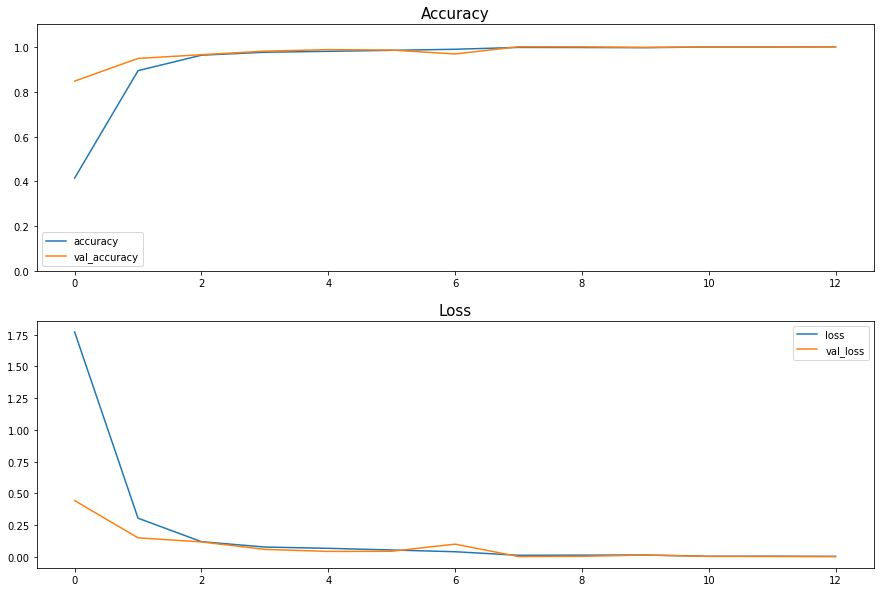

In [21]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10))
ax = axes.flat

pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot(ax=ax[0])
ax[0].set_title("Accuracy", fontsize = 15)
ax[0].set_ylim(0,1.1)

pd.DataFrame(history.history)[['loss','val_loss']].plot(ax=ax[1])
ax[1].set_title("Loss", fontsize = 15)
plt.show()

In [23]:
# Predict the label of the test_images
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)

# Get the accuracy score
acc = accuracy_score(y_test,pred)

# Display the results
print(f'{acc*100:.2f}% accuracy on the test set')

99.19% accuracy on the test set
